In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import pickle
from pytorch3d.structures import Meshes
import torch
import numpy as np
import math
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1" 

# from training.volumetric_rendering.camera_utils2 import transform_to_view_space, project_to_clip_space

from collections import OrderedDict
from pytorch3d.io import load_obj, save_obj


## Set up shells and Gaussians

In [11]:
_v_template, faces, aux = load_obj('assets/flame_uv_no_back_close_mouth_no_subdivision.obj', load_textures=False)

_faces = faces.verts_idx
_faces_uvs =  faces.textures_idx
_vertex_uvs = aux.verts_uvs

In [12]:
num_shells = 5

In [13]:
def generate_random_point_in_tetrahedron(vertices):
    # TODO: sample based on tet volume
    # Generate random barycentric coordinates
    r1 = np.random.random()
    r2 = np.random.random()
    r3 = np.random.random()
    r4 = np.random.random()

    # Ensure that the sum of barycentric coordinates is <= 1
    total = r1 + r2 + r3 + r4
    r1 /= total
    r2 /= total
    r3 /= total
    r4 /= total

    # Calculate the fourth barycentric coordinate
    # r4 = 1.0 - r1 - r2 - r3    

    # Calculate the random point using barycentric coordinates
    point = r1 * vertices[0] + r2 * vertices[1] + r3 * vertices[2] + r4 * vertices[3]

    return point, [r1, r2, r3, r4]


def generate_random_point_in_triangle(vertices):
    # Generate random barycentric coordinates
    r1 = np.random.random()
    r2 = np.random.random()
    r3 = np.random.random()
    # r4 = np.random.random()

    # print(r1, r2, r3)

    # Ensure that the sum of barycentric coordinates is <= 1
    total = r1 + r2 + r3 
    r1 /= total
    r2 /= total
    r3 /= total
    
    point = r1 * vertices[0] + r2 * vertices[1] + r3 * vertices[2] 
    return point, [r1, r2, r3]



class points:
    def __init__(self, coordinates= [], upper_traingle= [], lower_traingle= [], upper_uv= [], lower_uv= [], tet_bari= [], tex_up= [], tex_low= [], 
                 z_0 = [], z = [], z_1 = [], faces = []):
        self.coordinates = coordinates
        self.upper_traingle = upper_traingle
        self.lower_traingle = lower_traingle
        self.upper_uv = upper_uv
        self.lower_uv = lower_uv
        self.tet_bari = tet_bari
        self.tex_up = tex_up
        self.tex_low = tex_low
        self.z_0 = z_0
        self.z = z
        self.z_1 = z_1
        self.faces = faces


@torch.no_grad()
@torch.no_grad()
def generate_points(num_shells, faces, vertices, tex_coord, uv_faces):
   
        offset = torch.max(faces.reshape(-1)) 
        offset2 = torch.max(uv_faces.reshape(-1))
        orig_vertices = vertices.to(faces.device).reshape(-1, 3)
        vertices = orig_vertices

        vertices[:,0] = vertices[:,0] * 1.5
        tex_coord = tex_coord.to(faces.device).reshape(-1, 2).repeat(num_shells,1)
        print(tex_coord.shape)
        num1 = 1
        num2 = 1
     
        new_faces = []

        face_one = faces
        uv_faceone = uv_faces
        
        point_list = points()
        for i in range(1, num_shells):
            print(f"generating point @ shell {i}")
            
            face_two = face_one + offset + 1
            uv_facetwo = uv_faceone + offset2 + 1
            for face1, face2, uv_face1, uv_face2 in zip(face_one, face_two, uv_faceone, uv_facetwo):                            

                tetrahedra = []
                tetrahedra.append([vertices[face1[0]], vertices[face1[1]], vertices[face1[2]]])

                for jj in range(num1):                
                    for ii in range(num2):
                        point, uvw_ = generate_random_point_in_triangle(tetrahedra[jj])
                        texture_interp_up = tex_coord[uv_face1[0]] * uvw_[0] + tex_coord[uv_face1[1]] * uvw_[1] + tex_coord[uv_face1[2]] * uvw_[2]
                        point_list.coordinates.append(point)
                        point_list.upper_uv.append(torch.tensor(uvw_))
                        point_list.faces.append(face1)
                        point_list.tex_up.append(texture_interp_up)
                  

            face_one = face_two
            uv_faceone = uv_facetwo
        
        point_list.tex_up = torch.stack(point_list.tex_up)
        point_list.upper_uv = torch.stack(point_list.upper_uv)
        point_list.faces = torch.stack(point_list.faces)
        point_list.coordinates = torch.stack(point_list.coordinates)
      
        return point_list, vertices

@torch.no_grad()
def settings_(vertices, faces, uv_faces, num_shells, tex_coord, normal_scale=0.04, disable_small = False):
    faces = torch.tensor(faces.astype(np.int64)).to(vertices.device)    
    from deformer.deformer import get_shell_verts_from_base
    vertices = get_shell_verts_from_base(vertices, faces, normal_scale, num_shells)
    points_list, new_vertices  = generate_points(num_shells, faces, vertices, tex_coord, uv_faces)    

    return points_list, new_vertices

# shift and scale
v_template = _v_template * 2.9
v_template += torch.tensor([[0, 0.04, 0.12]])
point_list, new_vertices = settings_((v_template).unsqueeze(0), 
                                      _faces.numpy(), _faces_uvs, 
                                      num_shells, _vertex_uvs, normal_scale=0.03, 
                                      disable_small=False)
# print(total_features.shape)
print(point_list.tex_up.shape)

torch.Size([18300, 2])
generating point @ shell 1
generating point @ shell 2
generating point @ shell 3
generating point @ shell 4
torch.Size([28016, 2])


## Training

### Set up camera for rendering

In [14]:
from scene.cameras import Camera
import numpy as np
from utils.general_utils import PILtoTorch
from utils.graphics_utils import fov2focal,focal2fov
from torch import nn

from utils.graphics_utils import getWorld2View2, getProjectionMatrix

extrinsic = np.load('data/seed2022_stuttgart_hillside_2k_movcam_poses.npy')

extrinsic = extrinsic[..., :16].reshape(-1, 4, 4)


print("Extrinsic", extrinsic[0])

img_width = img_height = 512
fov_deg = 18.837
fovx = np.deg2rad(fov_deg)
fovy = focal2fov(fov2focal(fovx, img_width), img_height)
FovX = FovY = fovx
R = extrinsic[0][:3,:3]

T = np.linalg.inv(extrinsic[0])[:3, 3]
print("Transpose", T)

def focal2fov(focal, pixels):
    return 2*math.atan(pixels/(2*focal))

class Camera(nn.Module):
    def __init__(self, 
                 id__,
                 R, T, FoVx, FoVy, 
                 # image, gt_alpha_mask,
                 # image_name, 
                 trans=np.array([0.0, 0.0, 0.0]), scale=1.0, data_device = "cuda"
                 ):
        super(Camera, self).__init__()

        # self.uid = uid
        # self.colmap_id = colmap_id
        self.R = R
        self.T = T
        self.FoVx = FoVx
        self.FoVy = FoVy
        # self.image_name = image_name

        try:
            self.data_device = torch.device(data_device)
        except Exception as e:
            print(e)
            print(f"[Warning] Custom device {data_device} failed, fallback to default cuda device" )
            self.data_device = torch.device("cuda")

        self.image_width = 512
        self.image_height = 512

        self.zfar = 100.0
        self.znear = 0.01

        self.trans = trans
        self.scale = scale

        self.world_view_transform = torch.tensor(getWorld2View2(R, T, trans, scale)).transpose(0, 1).cuda()
        self.projection_matrix = getProjectionMatrix(znear=self.znear, zfar=self.zfar, fovX=self.FoVx, fovY=self.FoVy).transpose(0,1).cuda()
        self.full_proj_transform = (self.world_view_transform.unsqueeze(0).bmm(self.projection_matrix.unsqueeze(0))).squeeze(0)
        self.camera_center = self.world_view_transform.inverse()[3, :3]

        
id__ = 0

camera = Camera(id__, extrinsic[id__][:3,:3], np.linalg.inv(extrinsic[id__])[:3, 3], FovX, FovY, data_device="cuda")

Extrinsic [[ 9.9999964e-01  1.1779190e-04  8.5253199e-04 -2.1328165e-03]
 [ 0.0000000e+00 -9.9058944e-01  1.3686690e-01 -3.4240589e-01]
 [ 8.6063100e-04 -1.3686685e-01 -9.9058908e-01  2.6782000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]
Transpose [-1.7212625e-04  2.7373383e-02  2.6998615e+00]


### Initialize Gaussians and visualize to debug

In [15]:
# !pip install submodules/simple-knn

from gaussian_renderer import GaussianModel
from scene import Scene
from gaussian_renderer import render

gaussians = GaussianModel(point_list.coordinates.cpu().numpy(), point_list.tex_up, 3, num_shells-1)

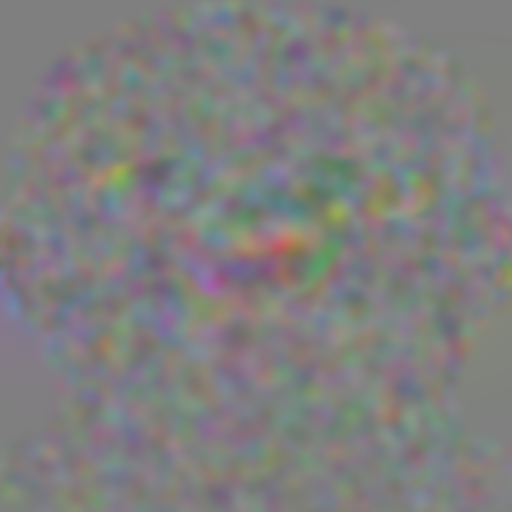

In [16]:
from IPython.display import display
from PIL import Image
bg_color = [0.5, 0.5, 0.5]
background = torch.tensor(bg_color, dtype=torch.float32, device= 'cuda:0')

class PipelineParams():
    def __init__(self):
        self.convert_SHs_python = True
        self.compute_cov3D_python = False
        self.debug = False

pipeline = PipelineParams()
camera = Camera(0, extrinsic[0][:3,:3], np.linalg.inv(extrinsic[0])[:3, 3], FovX, FovY, data_device="cuda")
out__ = render(camera, gaussians, pipeline, background)

rendering = out__["render"]

im = (np.uint8(rendering.detach().permute(1,2,0).cpu().numpy()*255))
display(Image.fromarray(im))
gaussians.save_ply("output/input.ply")

### Load data

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


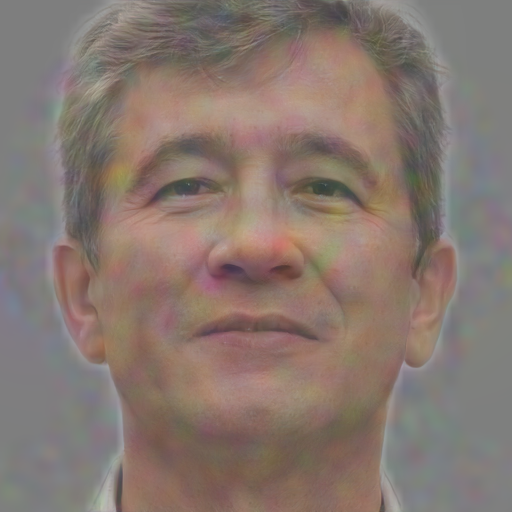

In [17]:
%pip install natsort
from natsort import natsorted
from glob import glob
x= 0

dir_ = natsorted(glob('data/seed2022_stuttgart_hillside_2k_movcam/*.png'))

from IPython.display import display
from PIL import Image

img_ = Image.open(dir_[x]) 
img_ = img_.resize((512, 512))
y = np.array(img_)
if y.shape[2] == 4:
    y = np.uint8((y[:,:,:3] * (y[:,:,3:]/255)) + ( 1-y[:,:,3:]/255)*127)
im = Image.fromarray(im//2 + y//2)
display(im)

In [18]:
### Start training

Epoch [0], Loss: 0.17114:   0%|                                                                                                                                           | 1/5000 [00:00<37:27,  2.22it/s]

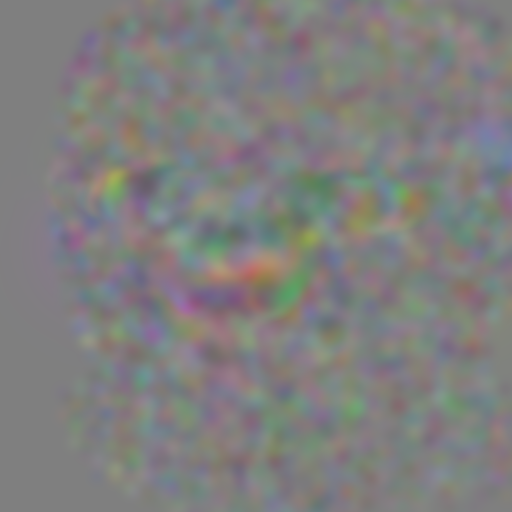

Epoch [1000], Loss: 0.07272:  20%|██████████████████████████▌                                                                                                          | 1000/5000 [00:33<02:08, 31.14it/s]

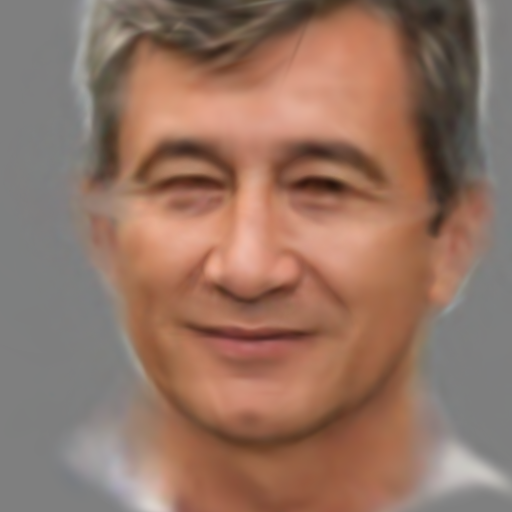

Epoch [2000], Loss: 0.05494:  40%|█████████████████████████████████████████████████████▏                                                                               | 2000/5000 [01:06<01:41, 29.53it/s]

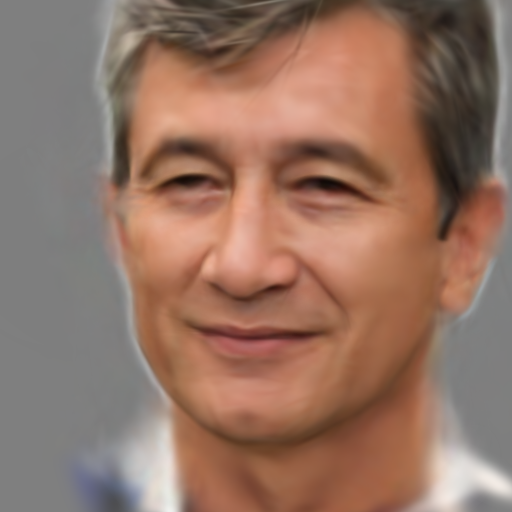

Epoch [3000], Loss: 0.03827:  60%|███████████████████████████████████████████████████████████████████████████████▊                                                     | 3000/5000 [01:40<01:08, 29.02it/s]

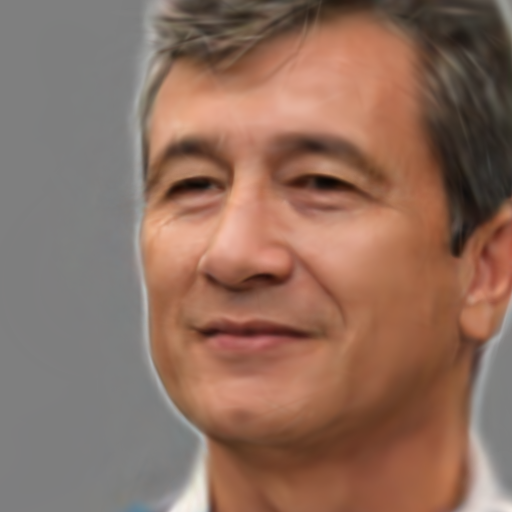

Epoch [4000], Loss: 0.05783:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 4000/5000 [02:14<00:33, 29.61it/s]

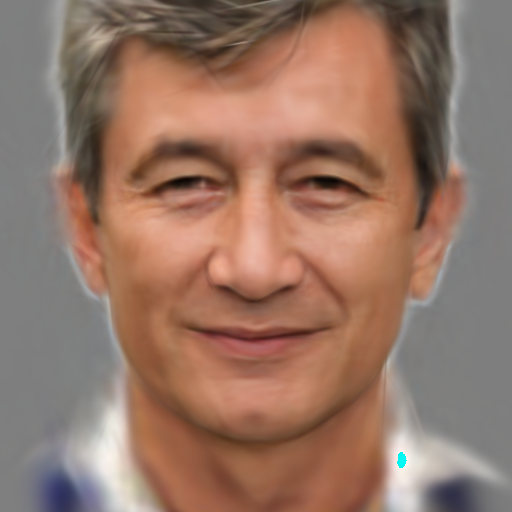

Epoch [4999], Loss: 0.03824: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [03:00<00:00, 29.68it/s]

In [19]:
import random
from utils.loss_utils import l1_loss, ssim
from PIL import Image

class OptimizationParams:
    def __init__(self):      
        self.feature_lr = 0.0025
      
        
opt  = OptimizationParams()
gaussians.training_setup(opt)

list_1 = [66,79,3,53,101,40,78,30,76,48,91,24,41,
          32,42,104,54,116,57,50,105,83,81,43,117,21,23,49,6,
          2,45,92,11,36,31,65,69,33,75,58,8,74,100,7,12,52,89,102,46,111,73,0,110,
          67,88,103,29,77,47,113,71,26,115,37,72,13,34,90,109,59,25,44,14,68,96,95,61,16,39,10,55,118,22,112]

list_eval = [63,60,9,15,107,56,99,108,1,4,70,38,27,51,17,18,20,97,93,85,35,114,5,119,19,87,82,62,84,64,28,98,80,94,106,86]

from tqdm import tqdm
iterations = 5000
progress_bar = tqdm(total=iterations, desc="Training")
for iteration in range(iterations):
        x = random.choice(list_1)
        gaussians.update_learning_rate(iteration)

        if iteration % 1000 == 0:
            gaussians.oneupSHdegree()

        camera = Camera(x, extrinsic[x][:3,:3], np.linalg.inv(extrinsic[x])[:3, 3], FovX, FovY, data_device="cuda")
        out = render(camera, gaussians, pipeline, background)
        rendering = out['render']
        viewspace_point_tensor = out['viewspace_points']
        visibility_filter = out['visibility_filter']
        radii = out['radii']

        img_ = Image.open(dir_[x]) 
        img_ = img_.resize((512, 512))
        y = np.array(img_)
        if y.shape[2] == 4:
            y = np.uint8((y[:,:,:3] * (y[:,:,3:]/255)) + ( 1-y[:,:,3:]/255)*127)
        y = ((torch.from_numpy(y).cuda()/255)).permute(2,0,1).unsqueeze(0)

       
        loss = (1.0 - 0.2) * l1_loss(rendering, y) + 0.2* (1.0 - ssim(rendering, y))
        # loss = (2.0) * l1_loss(rendering, y) + 0.2* (1.0 - ssim(rendering, y))
        loss.backward()
        
    
        gaussians.optimizer.step()
        gaussians.optimizer.zero_grad(set_to_none = True)

        progress_bar.set_description(f"Epoch [{iteration}], Loss: {loss.item():.5f}")
        progress_bar.update(1)        

        if iteration % 1000 ==0:              
            from IPython.display import display
            from PIL import Image
            # print(gaussians._opacity.shape)
            with torch.no_grad():
                # bg_color = [1, 1, 1]
                # background = torch.tensor(bg_color, dtype=torch.float32, device= 'cuda:0')
                out = render(camera, gaussians, pipeline, background)
                rendering = out['render']
                im2 = gaussians.opacity_activation(gaussians._opacity[0].flip(1).repeat(1,1,3))
                im2 = (np.uint8(im2.clone().detach().cpu().numpy()*255))
                im = (np.uint8(rendering.clone().detach().permute(1,2,0).cpu().numpy()*255))
                im = Image.fromarray(im)
                display(im)
               


## Save results

In [20]:
# Save results
import pickle
with torch.no_grad():    
    # Save the object to a pickle file
    with open("output/point_list.pkl", "wb") as f:
        pickle.dump(point_list, f)
    with open("output/gaussians.pkl", "wb") as f:
        pickle.dump(gaussians, f)
    with open("output/camera.pkl", "wb") as f:
        pickle.dump(camera, f)
    gaussians.save_ply(os.path.join("output", "point_cloud", "iteration_%d" % iterations, "point_cloud.ply"), )


## Evaluation PSNR test

In [ ]:
import torch
import torch.nn.functional as F
from PIL import Image

def compute_psnr(image1, image2, max_pixel_value=1.0):
    mse = F.mse_loss(image1, image2)
    psnr = 20 * torch.log10(max_pixel_value / torch.sqrt(mse))
    return psnr

total_psnr = 0
# x= random.choice(list_eval)
# for x in range(120):
for x in list_eval:
    img_ = Image.open(dir_[x]) 
    img_ = img_.resize((512, 512))
    y = np.array(img_)
    if y.shape[2] == 4:
        y = np.uint8((y[:,:,:3] * (y[:,:,3:]/255)) + ( 1-y[:,:,3:]/255)*127)
    y = ((torch.from_numpy(y).cuda()/255)).permute(2,0,1) #.unsqueeze(0)
    camera  = Camera(x, extrinsic[x][:3,:3], np.linalg.inv(extrinsic[x])[:3, 3], FovX, FovY, data_device="cuda")
    out = render(camera, gaussians, pipeline, background)
    rendering = out['render']
    psnr_value = compute_psnr(y, rendering)
    total_psnr += psnr_value.item()

average_psnr = total_psnr / len(list_eval)
print(f"Average PSNR: {average_psnr} dB")